In [ ]:
import sys
from pathlib import Path

project_root = Path.cwd().parents[0]  # importing functions from other folders
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from _data.data_utils import read_in
from _fitting.fitting_utils import hist_plot, CI_plot, CI_plot_alt, CI_plot_both, plot_posteriors_side_by_side
import pymc as pm
import arviz as az
from patsy import dmatrix
import nutpie
import time
from pprint import pprint
from IPython.display import display
import seaborn as sns
from pymc.variational.callbacks import CheckParametersConvergence

az.style.use("arviz-darkgrid")


if '___laptop' in os.listdir('../'):
    # laptop folder
    folder = "../../_data/p-dengue/"
elif '___server' in os.listdir('../'):
    # server folder
    folder = "../../../../../data/lucaratzinger_data/p_dengue/"

In [2]:
data = read_in(folder, admin=2, max_lag=6)
data = data.dropna()
data = data.loc[data['year']<2020, :]

rng = np.random.default_rng(42)
keep_admin2 = rng.choice(
    data["admin2"].unique(),
    size=int(0.5 * data["admin2"].nunique()),
    replace=False
)
#data = data[data["admin2"].isin(keep_admin2)]

---
# Poisson Intercept Only

In [3]:
model_intercept_p = pm.Model()
with model_intercept_p:
    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=2.5)

    # Link
    log_mu = (intercept +
              pm.math.log(data['population']))

    # Likelihood
    y_obs = pm.Poisson('y_obs', mu=pm.math.exp(log_mu), observed=data['cases'])

In [106]:
with model_intercept_nb:
    s = time.time()
    idata = pm.sample(tune=1000, draws=2000, chains=4, discard_tuned_samples=True, nuts_sampler="nutpie")
    s1 = time.time()
    pm.compute_log_likelihood(idata, progressbar=False)
    s2 = time.time()
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=42, progressbar=False)
    print(f'Posterior Sampling {s1 - s:.2f} seconds')
    print(f'Log Likelihood Compute {s2 - s1:.2f} seconds')
    print(f'Posterior Predictive Sampling {time.time()-s2:.2f} seconds')

Progress,Draws,Divergences,Step Size,Gradients/Draw
,3000,0,1.17,3
,3000,0,1.10,3
,3000,0,1.20,3
,3000,0,1.19,3


Sampling: [y_obs]


Posterior Sampling 8.23 seconds
Log Likelihood Compute 3.56 seconds
Posterior Predictive Sampling 14.83 seconds


---
# adagrad_window

In [104]:
model_intercept_p = pm.Model()
with model_intercept_p:
    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=2.5)

    # Link
    log_mu = (intercept +
              pm.math.log(data['population']))

    # Likelihood
    y_obs = pm.Poisson('y_obs', mu=pm.math.exp(log_mu), observed=data['cases'])

In [113]:
with model_intercept_nb:
    # mean_field = pm.fit()
    mean_field = pm.fit(100_000, obj_optimizer=pm.adam(learning_rate=1e-3), method='advi',
        callbacks=[CheckParametersConvergence(diff="absolute")])

Output()

Convergence achieved at 73300
Interrupted at 73,299 [73%]: Average Loss = 95,477


array([<Axes: title={'center': 'intercept'}>,
       <Axes: title={'center': 'alpha'}>], dtype=object)

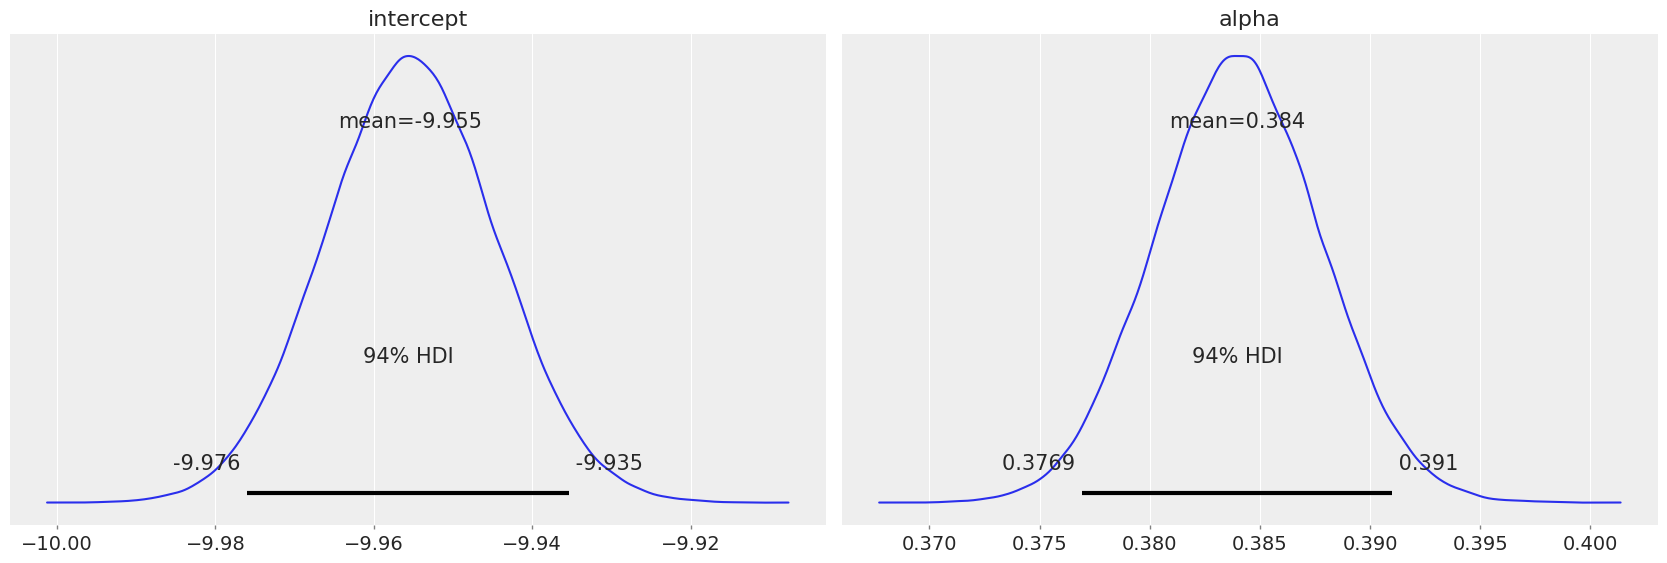

In [132]:


# Plot traces and posterior densities
az.plot_posterior(mean_field.sample(100000), round_to=4)

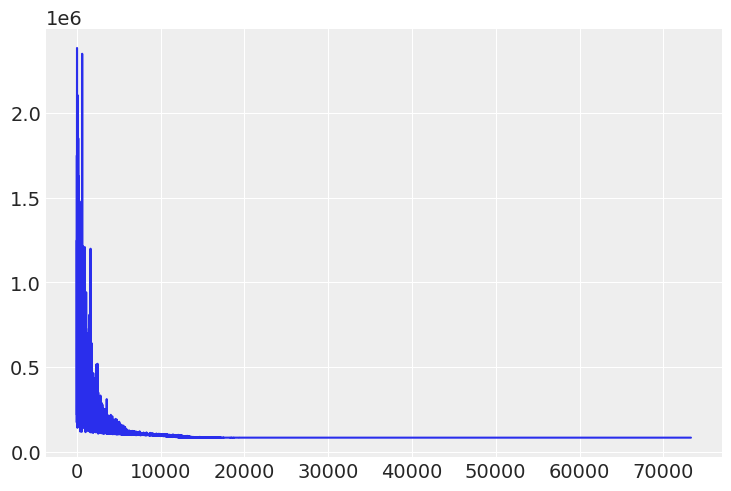

In [133]:
plt.plot(mean_field.hist);

In [134]:
approx_sample = mean_field.sample(9000)

In [149]:
def plot_posteriors_side_by_side(idata1, idata2, var_names=None, figsize=(12, 3)):
    """
    Plot posterior distributions for the same variables from two InferenceData objects
    side by side (each variable has a row, two columns: idata1 and idata2).
    """
    if var_names is None:
        var_names = list(idata1.posterior.data_vars)
    
    n_vars = len(var_names)
    fig, axes = plt.subplots(n_vars, 2, figsize=(figsize[0], figsize[1]*n_vars), squeeze=False)
    
    for i, var in enumerate(var_names):
        # Left column: idata1
        az.plot_posterior(idata1, var_names=[var], ax=axes[i, 0], color="blue", hdi_prob=0.95, round_to=4)
        axes[i, 0].set_title(f"{var} - idata1")
        
        # Right column: idata2
        az.plot_posterior(idata2, var_names=[var], ax=axes[i, 1], color="red", hdi_prob=0.95, round_to=4)
        axes[i, 1].set_title(f"{var} - idata2")
    
    plt.show()


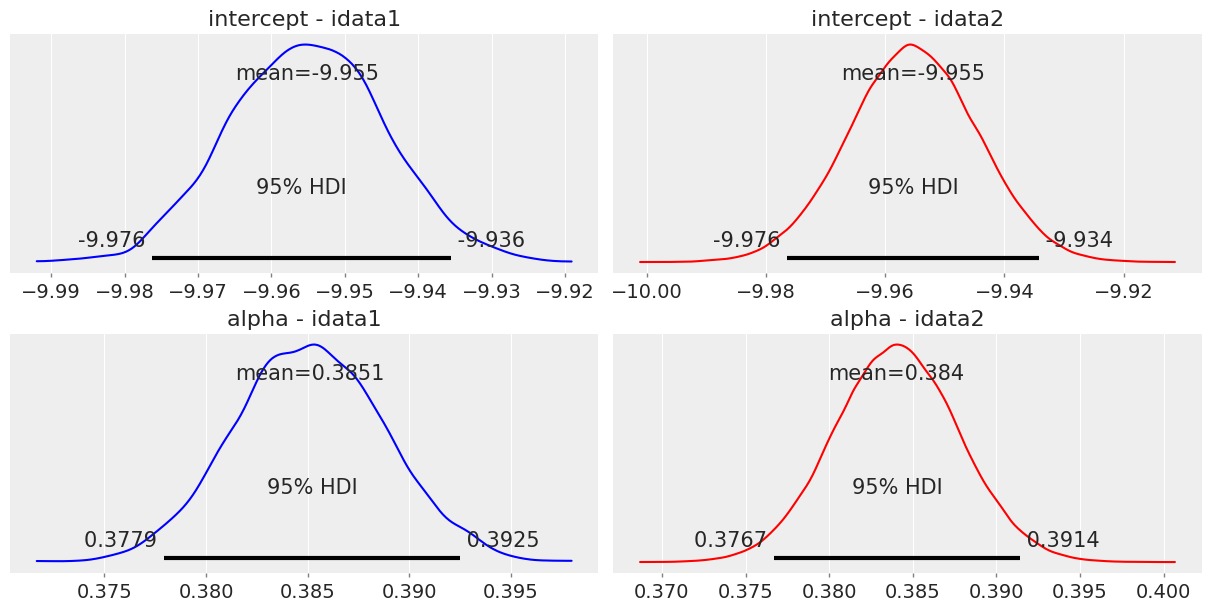

In [150]:
plot_posteriors_side_by_side(idata, mean_field.sample(100000), var_names=['intercept', 'alpha'])

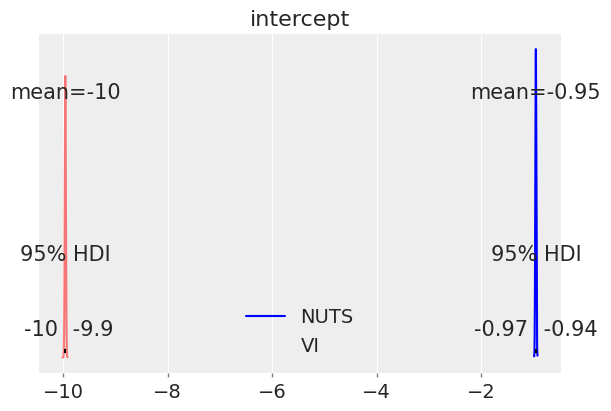

In [137]:
fig, ax = plt.subplots(figsize=(6,4))
az.plot_posterior(idata, ax=ax, color="blue", hdi_prob=0.95)
az.plot_posterior(mean_field.sample(100000), ax=ax, color="red", hdi_prob=0.95, alpha=0.5)
ax.legend(["NUTS", "VI"])
plt.show()

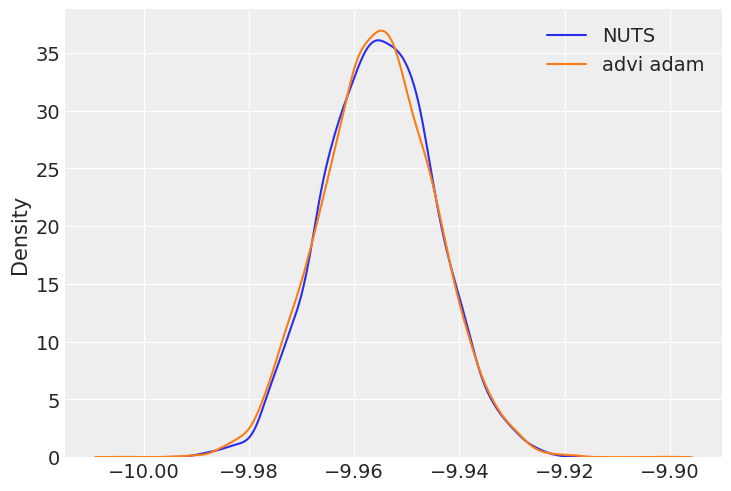

In [135]:
sns.kdeplot(idata.posterior["intercept"].values.flatten(), label="NUTS")
sns.kdeplot(approx_sample.posterior["intercept"].values.flatten(), label="advi adam")
plt.legend();

---

In [46]:
model_intercept_p = pm.Model()
with model_intercept_p:
    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=2.5)

    # Link
    log_mu = (intercept +
              pm.math.log(data['population']))

    # Likelihood
    y_obs = pm.Poisson('y_obs', mu=pm.math.exp(log_mu), observed=data['cases'])

In [107]:
model_intercept_nb = pm.Model()
with model_intercept_nb:
    # Priors
    alpha = pm.Exponential("alpha", 0.5)
    intercept = pm.Normal("intercept", mu=0, sigma=2.5)

    # Link
    log_mu = (intercept +
              pm.math.log(data['population']))

    # Likelihood
    y_obs = pm.NegativeBinomial('y_obs', mu=pm.math.exp(log_mu), alpha=alpha, observed=data['cases'])

In [62]:
with model_intercept_nb:
    # mean_field = pm.fit()
    mean_field = pm.fit(100_000, method='advi',
        callbacks=[CheckParametersConvergence(diff="absolute")])

Output()

Convergence achieved at 68300
Interrupted at 68,299 [68%]: Average Loss = 1.1099e+05


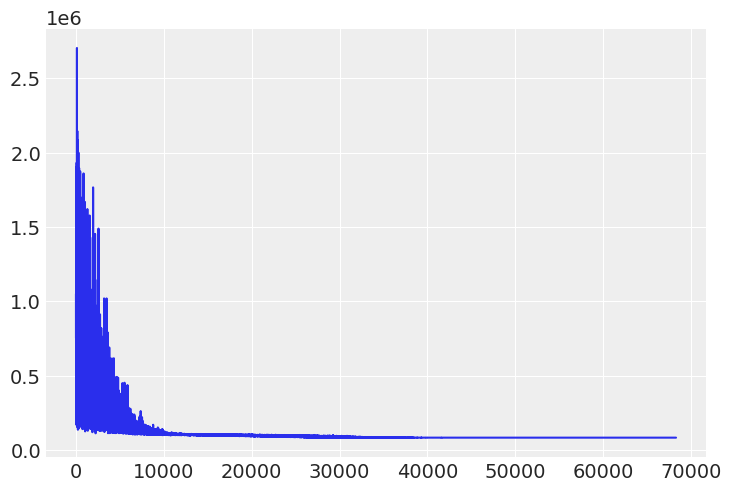

In [63]:
plt.plot(mean_field.hist);

In [64]:
approx_sample = mean_field.sample(9000)

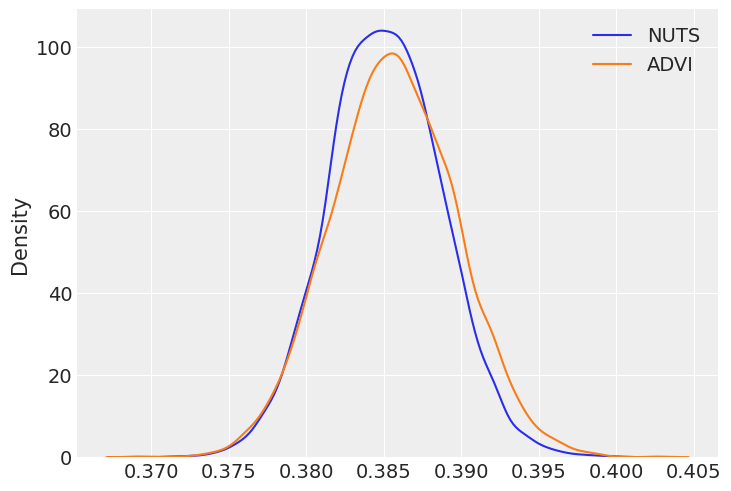

In [66]:
sns.kdeplot(idata.posterior["alpha"].values.flatten(), label="NUTS")
sns.kdeplot(approx_sample.posterior["alpha"].values.flatten(), label="ADVI")
plt.legend();

In [77]:
model_intercept_nb = pm.Model()
with model_intercept_nb:
    # Priors
    alpha = pm.Exponential("alpha", 0.5)
    intercept = pm.Normal("intercept", mu=0, sigma=2.5)

    # Link
    log_mu = (intercept +
              pm.math.log(data['population']))

    # Likelihood
    y_obs = pm.NegativeBinomial('y_obs', mu=pm.math.exp(log_mu), alpha=alpha, observed=data['cases'])

In [89]:
advi

In [90]:
with model_intercept_nb:
    advi = pm.fit(2_000, method="advi")
    # sample a few draws from ADVI
    advi_samples = advi.sample(1)  # returns InferenceData with posterior

    # extract the first draw as a start dictionary for SVGD
    start = {var: advi_samples.posterior[var].values.flatten()[0]
             for var in advi_samples.posterior.data_vars}
    # mean_field = pm.fit()
    mean_field = pm.fit(1_000, method='svgd', start=start,
        callbacks=[CheckParametersConvergence(diff="absolute")], inf_kwargs=dict(n_particles=10))

Output()

Finished [100%]: Average Loss = 4.3193e+05


Output()

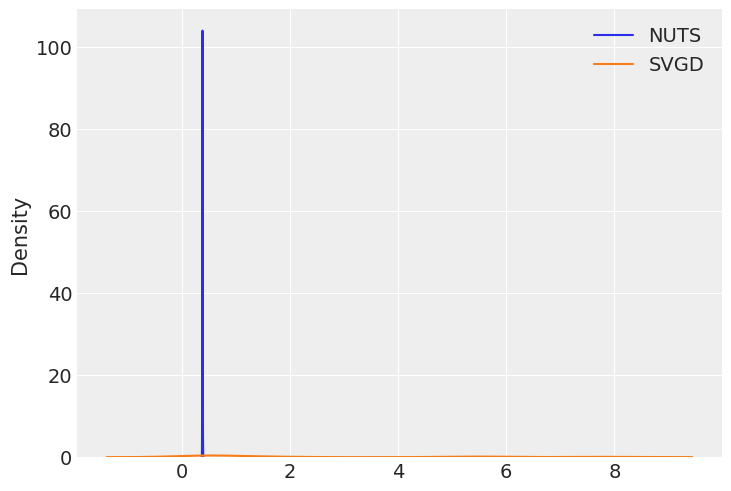

In [91]:
approx_sample = mean_field.sample(2000)
sns.kdeplot(idata.posterior["alpha"].values.flatten(), label="NUTS")
sns.kdeplot(approx_sample.posterior["alpha"].values.flatten(), label="SVGD")
plt.legend();

---